# Inference and Capital Punishment, Part 1

Iinvestigate the data relevant to a hotly debated social issue: the possible influence of capital punishment (the death penalty) on murder rates in the United States.

In Part 1:

1. Test whether observed data appears to be a random sample from a distribution.
2. Analyze a natural experiment.
3. Implement and interpret a sign test.
4. Create a function to run a general hypothesis test.
5. Analyze visualizations and draw conclusions from them.


In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from gofer.ok import check

In [2]:
murder_rates = Table.read_table('crime_rates.csv').select('State', 'Year', 'Population', 'Murder Rate')
murder_rates.set_format("Population", NumberFormatter)

State,Year,Population,Murder Rate
Alaska,1960,"226,167",10.2
Alaska,1961,"234,000",11.5
Alaska,1962,"246,000",4.5
Alaska,1963,"248,000",6.5
Alaska,1964,"250,000",10.4
Alaska,1965,"253,000",6.3
Alaska,1966,"272,000",12.9
Alaska,1967,"272,000",9.6
Alaska,1968,"277,000",10.5
Alaska,1969,"282,000",10.6


## 1. Murder rates


1) What year(s) the death penalty was introduced in each state (if any).

2) Day to day data about when murders occurred.

3) What year(s) the death penalty was abolished in each state (if any).

4) Rates of other crimes in each state.

In [3]:
extra_info = [1,3]

In [5]:
# The next lines are provided for you.  They create a table
# containing only the Alaska information and one containing
# only the Minnesota information.
ak = murder_rates.where('State', 'Alaska').drop('State', 'Population').relabeled(1, 'Murder rate in Alaska')
mn = murder_rates.where('State', 'Minnesota').drop('State', 'Population').relabeled(1, 'Murder rate in Minnesota')

# Fill in this line to make a table like the one pictured above.
ak_mn = ak.join("Year",mn,"Year")
ak_mn

Year,Murder rate in Alaska,Murder rate in Minnesota
1960,10.2,1.2
1961,11.5,1
1962,4.5,0.9
1963,6.5,1.2
1964,10.4,1.4
1965,6.3,1.4
1966,12.9,2.2
1967,9.6,1.6
1968,10.5,2.2
1969,10.6,1.9


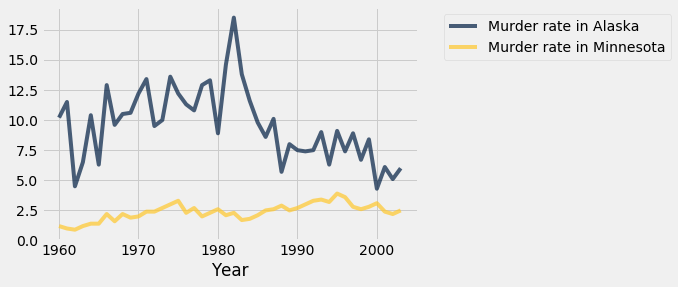

In [6]:
# Draw your line plot here
ak_mn.plot("Year")

In [8]:
# Compare the murder rates of any two states by filling in the blanks below

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def state(state1, state2):
    state1_table = murder_rates.where('State', state1).drop('State', 'Population').relabeled(1, 'Murder rate in {}'.format(state1))
    state2_table = murder_rates.where('State', state2).drop('State', 'Population').relabeled(1, 'Murder rate in {}'.format(state2))
    s1_s2 = state1_table.join("Year",state2_table,"Year")
    s1_s2.plot('Year')
    plots.show()

states_array = murder_rates.group('State').column('State')

_ = interact(state,
             state1=widgets.Dropdown(options=list(states_array),value='California'),
             state2=widgets.Dropdown(options=list(states_array),value='New York')
            )

interactive(children=(Dropdown(description='state1', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkans…

In [9]:
 data_for_year = murder_rates.select("Year","Murder Rate").sort("Murder Rate",descending = True)
data_for_year

Year,Murder Rate
1993,20.3
1980,20
1994,19.8
1972,18.5
1982,18.5
1974,17.8
1981,17.5
1979,17.5
1996,17.5
1992,17.4


array(['California', 'Mississippi', 'Texas', 'New York', 'Louisiana'],
      dtype='<U14')

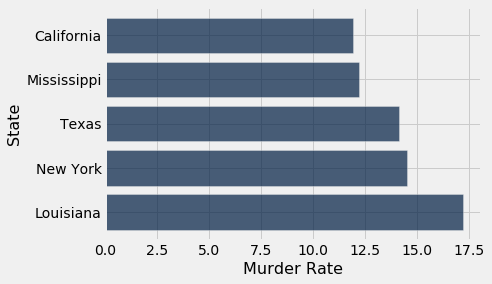

In [10]:
def most_murderous(year):
    # Assign most to a table of the most murderous states this year in ascending order.
    data_for_year = murder_rates.where("Year",year)
    sorted_data = data_for_year.sort("Murder Rate",descending = True)
    top_5 = sorted_data.take(np.arange(5)).sort("Murder Rate")
    top_5.barh('State', 'Murder Rate')
    return top_5.column('State')

most_murderous(1990) # California, Mississippi, ..., 

*Hint*: Recall the formula given at the beginning of the project:

$$\text{murder rate for state X in year Y} = \frac{\text{number of murders in state X in year Y}}{\text{population in state X in year Y}}*100000$$


In [12]:
ca = murder_rates.where('State', are.equal_to('California'))
def murder_number (year):
    murder_year = ca.where("Year",year)
    return murder_year.column(3).item(0)/100000*murder_year.column(2).item(0)
  
ca_change = murder_number(1988)-murder_number(1975)
np.round(ca_change)

726.0

# 2. Changes in Murder Rates

In this section, we'll see how to test this null hypothesis: "For a set of U.S. states, the murder rate was equally likely to go up or down each year."

Murder rates vary widely across states and years, presumably due to the vast array of differences among states and across US history. Rather than attempting to analyze rates themselves, here we will restrict our analysis to whether or not murder rates increased or decreased over certain time spans. **We will not concern ourselves with how much rates increased or decreased; only the direction of the changes** - whether they increased or decreased.

The `np.diff` function takes an array of values and computes the differences between adjacent items of a list or array as such:

    [item 1 - item 0 , item 2 - item 1 , item 3 - item 2, ...]

Instead, we may wish to compute the difference between items that are two positions apart. For example, given a 5-element array, we may want:

    [item 2 - item 0 , item 3 - item 1 , item 4 - item 2]
    
The `diff_n` function below computes this result. Don't worry if the implementation uses unfamiliar features of Python, as long as you understand its behavior.

In [14]:
def diff_n(values, n):
    return np.array(values)[n:] - np.array(values)[:-n]

diff_n(make_array(1, 10, 100, 1000, 10000), 2)

array([  99,  990, 9900])

In [15]:
def two_year_changes(rates):
    "Return the number of increases minus the number of decreases after two years."
    return np.count_nonzero(diff_n(rates,2)>0) - np.count_nonzero(diff_n(rates,2)<0)

print('Alaska:',    two_year_changes(ak.column('Murder rate in Alaska')))
print('Minnesota:', two_year_changes(mn.column('Murder rate in Minnesota')))

Alaska: -5
Minnesota: 6


In [17]:
# recheck the code when you have time

states = murder_rates.sort('State',distinct = True).column(0)
change = make_array()
for i in np.arange(len(states)):
    rate_difference = two_year_changes(murder_rates.where("State",states[i]).column(3))
    change = np.append(change,rate_difference)
    
changes_by_state = Table().with_columns("State",states,"Murder Rate two_year_changes",change)
changes_by_state

State,Murder Rate two_year_changes
Alabama,-6
Alaska,-5
Arizona,1
Arkansas,-1
California,17
Colorado,-4
Connecticut,4
Delaware,-3
Florida,-6
Georgia,-3


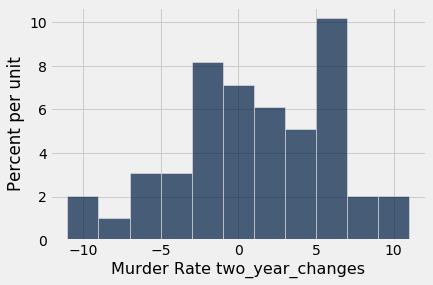

In [18]:
# Here is a histogram of the two-year changes for the states.
# Since there are 50 states, each state contributes 2% to one bar.
changes_by_state.hist("Murder Rate two_year_changes", bins=np.arange(-11, 12, 2))

In [20]:
total_changes = sum(change)
print('Total increases minus total decreases, across all states and years:', total_changes)

Total increases minus total decreases, across all states and years: 45.0


In [22]:
pds = make_array()
for i in np.arange(len(states)):
    pd = murder_rates.where('State',states[i]).num_rows-2
    pds = np.append(pds,pd)
num_changes = sum(pds)
num_changes

2100.0

The cell below samples increases and decreases at random from a uniform distribution 100 times. The final column of the resulting table gives the number of increases and decreases that resulted from sampling in this way. **Using `sample_from_distribution` is faster than using `sample` followed by `group` to compute the same result.**

In [24]:
uniform = Table().with_columns(
    "Change", make_array('Increase', 'Decrease'),
    "Chance", make_array(0.5,        0.5))
uniform.sample_from_distribution('Chance', 100)

Change,Chance,Chance sample
Increase,0.5,53
Decrease,0.5,47


In [27]:
def simulate_under_null(num_chances_to_change):
    """Simulates some number changing several times, with an equal
    chance to increase or decrease.  Returns the value of our
    test statistic for these simulated changes.
    
    num_chances_to_change is the number of times the number changes.
    """
    sample = uniform.sample_from_distribution("Chance",100)
    return sample.column(2).item(0)-sample.column(2).item(1)

uniform_samples = make_array()
for i in np.arange(5000):
    uniform_samples = np.append(uniform_samples, simulate_under_null(num_changes))

simulated_changes = Table().with_column('Test statistic under null', uniform_samples)
simulated_changes

Test statistic under null
4
-22
-6
-2
-16
-12
2
12
0
10


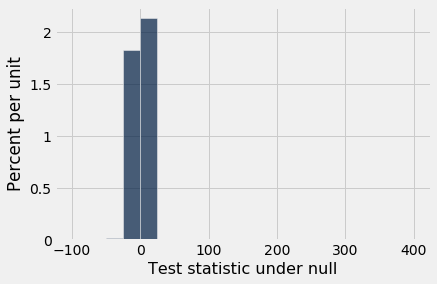

In [28]:
# Run this cell to visualize the empirical distribution of 
# the test statistic under the null hypothesis.
simulated_changes.hist(0, bins=np.arange(-100, 400+25, 25))

In [29]:
which_side = "Right"
if np.count_nonzero(uniform_samples > 0)-np.count_nonzero(uniform_samples < 0) > 0:
    reject_null = True
else:
    reject_null = False
    
reject_null

False